# 불균형 데이터로 신용카드 사기탐지 모델 구현하기

## 실습 가이드
1. 데이터를 다운로드하여 Colab에 불러옵니다.
2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
3. 코드는 위에서부터 아래로 순서대로 실행합니다.
4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.

## Step 0. 사기탐지 분류 모형 개요

### 금융 데이터의 특성 (Review)
- 1) 이종(heterogeneous) 데이터의 결합
- 2) <b>분포의 편향성(skewness)</b>
- 3) 분류 레이블의 불명확성
- 4) 변수의 다중공선성(multicollinearity)
- 5) 변수의 비선형성
- 그 외 현실적인 규제·수집·저장 등의 한계 때문에 데이터가 불완전(missing, truncated, censored)할 수 있음

사기탐지(Fraud Detection) 분류는 주로 2)와 관련한 금융 데이터의 특성을 가진 문제입니다. 

### 불균형 데이터의 머신러닝

- 데이터 불균형(Imbalanced Data): 머신러닝의 지도학습에서 분류하기 위한 각 클래스(레이블)에 해당하는 데이터의 양에 차이가 큰 경우
- 특정 클래스가 부족할 때 생기는 문제: (1) 과대적합, (2) 알고리즘이 수렴하지 않는 현상 발생


- 1) X (피처)의 불균형
    - 범주변수일 경우 범주에 따라 빈도가 낮을 수 있음
    - 고차원 피처 공간의 축소(Feature Transformation)
    - PCA, t-SNE 등의 알고리즘 사용
    
    
- 2) y (타겟)의 불균형
    - 여신(대출), 수신(적금), 보험(클레임), 카드(사기탐지), 거시경제(불황) 등 대부분의 금융 데이터는 희소 타겟 문제
    - 리샘플링(Resampling)으로 저빈도 데이터를 극복
    - 무선 과대표집(Random Oversampling), 무선 과소표집(Random Undersampling), SMOTE, Tomek Links 등의 알고리즘 사용

### 학습목표

- 1) 불균형 데이터 분류 문제에 대한 이해
- 2) 피처 변환 알고리즘의 이해
- 3) 과대적합 발생시 해결 방법 습득
- 4) 리샘플링 알고리즘에 대한 이해
- 5) 불균형 데이터를 이용한 분류 결과의 올바른 해석 방법 습득

## Step 1. 데이터를 학습에 맞게 변환하기

- 데이터 소개
https://www.kaggle.com/mlg-ulb/creditcardfraud

In [98]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [99]:
import warnings
warnings.filterwarnings("ignore")

### 문제 01. 데이터 확인하기

In [100]:
filepath = 'https://github.com/mchoimis/financialml/raw/main/fraud/'

In [101]:
# 파일 불러오기
df =  pd.read_csv('creditcard.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [102]:
# 로드한 데이터의 맨 윗 30개 행 확인하기
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [103]:
# Missing 여부 확인하기
df.isnull().sum().head()

Time    0
V1      0
V2      0
V3      0
V4      0
dtype: int64

In [104]:
print(f'정상 거래 비율 = {round(df["Class"].value_counts()[0]/len(df) * 100,3)}%')
print(f'사기 탐지 = {round(df["Class"].value_counts()[1]/len(df) * 100,3)}%')

정상 거래 비율 = 99.827%
사기 탐지 = 0.173%


In [105]:
print('Target class is ', '{0:0.4f}'.format(round(df["Class"].value_counts()[1]/len(df) * 100,3)), '%')

Target class is  0.1730 %


- #### 사기 비율이 너무 적다.

### 문제 02. 변수의 스케일 변환하기

### 참고: scikit-learn이 제공하는 스케일러 (Review)

scikit-learn에서 제공하는 피처 스케일러(scaler)
- `StandardScaler`: 기본 스케일, 각 피처의 평균을 0, 표준편차를 1로 변환
- `RobustScaler`: 위와 유사하지만 평균 대신 중간값(median)과 일분위, 삼분위값(quartile)을 사용하여 이상치 영향을 최소화
- `MinMaxScaler`: 모든 피처의 최대치와 최소치가 각각 1, 0이 되도록 스케일 조정
- `Normalizer`: 피처(컬럼)이 아니라 row마다 정규화되며, 유클리드 거리가 1이 되도록 데이터를 조정하여 빠르게 학습할 수 있게 함

<p> 스케일 조정을 하는 이유는 데이터의 값이 너무 크거나 작을 때 학습이 제대로 되지 않을 수도 있기 때문입니다. <b> 또한 스케일의 영향이 절대적인 분류기(예: knn과 같은 거리기반 알고리즘)의 경우, 스케일 조정을 필수적으로 검토해야 합니다. </b>
    
<p> 반면 어떤 항목은 원본 데이터의 분포를 유지하는 것이 나을 수도 있습니다. 예를 들어, 데이터가 거의 한 곳에 집중되어 있는 feature를 표준화시켜 분포를 같게 만들었을 때, 작은 단위의 변화가 큰 차이를 나타내는 것처럼 학습될 수도 있습니다. 또한 스케일의 영향을 크게 받지 않는 분류기(예: 트리 기반 앙상블 알고리즘)를 사용할 경우에도 성능이 준수하게 나오거나 과대적합(overfitting)의 우려가 적다면 생략할 수도 있습니다.
    
<p> <b>스케일 조정시 유의해야할 점은 원본 데이터의 의미를 잃어버릴 수 있다는 것입니다.</b> 최종적으로 답을 구하는 것이 목적이 아니라 모델의 해석이나 향후 다른 데이터셋으로의 응용이 더 중요할 때 원 피처에 대한 설명력을 잃어버린다면 모델 개선이 어려울 수도 있습니다. 이 점을 함께 고려하시면 좋겠습니다.

In [106]:
# 데이터 스케일 조정하기
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler =  StandardScaler()
# robust == strong
rob_scaler =  RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1)) 
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1)) 

# 원 데이터에서 Time 컬럼과 Amount 컬럼 제외하기
df.drop(['Time','Amount'],axis=1, inplace=True)

In [107]:
# 스케일 조정된 컬럼 추가하기
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount) # 컬럼 0에자리에 데이터입력
df.insert(1, 'scaled_time', scaled_time)     #컬럼 1에 자리에 데이터 입력

## 스케일 조정된 데이터 확인하기
print(scaled_amount.head())
print(scaled_time.head())
df.head()

0    1.783274
1   -0.269825
2    4.983721
3    1.418291
4    0.670579
Name: scaled_amount, dtype: float64
0   -0.994983
1   -0.994983
2   -0.994972
3   -0.994972
4   -0.994960
Name: scaled_time, dtype: float64


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### 문제 03. 샘플 데이터 나누기

In [108]:
# X와 y 데이터 셋 만들기
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit  
# 이처럼 이상치가 많이 없는(사기 비율이 매우 적다) 데이터 셋을 분류할때는  StratifiedShuffleSplit가 효과적이다.
from sklearn.model_selection import KFold, StratifiedKFold

X = df.drop('Class', axis=1)
y = df['Class']

# 층위 샘플링으로 데이터 나누기
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
        print('train {}, test {}'.format(test_index,test_index))
        X_train, X_test = X.iloc[train_index],X.iloc[test_index]
        y_train, y_train = y.iloc[train_index],y.iloc[test_index]
        

  # 채워주세요


train [    0     1     2 ... 57017 57018 57019], test [    0     1     2 ... 57017 57018 57019]
train [ 30473  30496  31002 ... 113964 113965 113966], test [ 30473  30496  31002 ... 113964 113965 113966]
train [ 81609  82400  83053 ... 170946 170947 170948], test [ 81609  82400  83053 ... 170946 170947 170948]
train [150654 150660 150661 ... 227866 227867 227868], test [150654 150660 150661 ... 227866 227867 227868]
train [212516 212644 213092 ... 284804 284805 284806], test [212516 212644 213092 ... 284804 284805 284806]


In [109]:
# 클래스의 skew 정도가 매우 높기 때문에 클래스간 분포를 맞추는 것이 필요합니다.
# subsample 구축 전 셔플링을 통해 레이블이 한쪽에 몰려있지 않도록 하겠습니다.
df = df.sample(frac=1)
# 데이터 준비
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
# 데이터 셔플하기
new_df = normal_distributed_df.sample(frac=1, random_state=0)
# 셔플한 새로운 데이터 셋 확인
new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
219025,-0.244673,0.668159,0.114965,0.766762,-0.494132,0.116772,0.868169,-0.477982,0.438496,0.063073,...,0.062199,-0.284413,-0.706865,0.131405,0.600742,-0.604264,0.262938,0.099145,0.010810,1
139267,0.111786,-0.018903,-0.933927,0.056716,1.995246,-0.775301,-0.134436,-1.464158,0.260727,0.045247,...,-0.032280,-0.102207,-0.673352,0.192986,0.669857,-0.503388,0.566288,-0.029985,0.116179,0
143335,3.226717,0.006967,-6.713407,3.921104,-9.746678,5.148263,-5.151563,-2.099389,-5.937767,3.578780,...,0.135711,0.954272,-0.451086,0.127214,-0.339450,0.394096,1.075295,1.649906,-0.394905,1
268831,-0.028645,0.924705,0.309445,-0.154803,0.506564,-1.958505,-0.200893,-0.203742,-0.016888,0.163345,...,-0.027218,-0.159451,-0.689214,0.316111,0.607498,-0.811735,-0.795314,0.016527,0.002199,0
101955,0.391253,-0.196184,0.976833,-0.664823,1.866841,1.662617,-1.416433,1.170487,-1.333644,0.570797,...,-0.083294,0.132579,0.771115,-0.241966,0.062847,0.567334,-0.098903,0.108052,0.034390,0


In [110]:
print(df.head())
print(df.info())
print('-====== = = = = = = = =')

print(fraud_df.head(5))
print(fraud_df.info())
print('-====== = = = = = = = =')
print(non_fraud_df.head(5))
print(non_fraud_df.info())
print('-====== = = = = = = = =')
print(normal_distributed_df.head(5))
print(normal_distributed_df.info())
print('-====== = = = = = = = =')
print(new_df.head(5))
print(new_df.info())

        scaled_amount  scaled_time        V1        V2        V3        V4  \
208099       0.012716     0.614199 -0.634800  1.497741 -0.393760  0.753446   
1171        -0.275554    -0.984269 -0.416621  1.019731  1.337170 -0.203938   
104844      -0.269825    -0.181381  1.275341  0.549224 -0.099111  1.101659   
220170       2.076853     0.673904 -5.121007 -5.152164 -0.373245 -1.529093   
68173        0.530846    -0.373900 -1.090235  0.884093  0.971063 -1.142032   

              V5        V6        V7        V8  ...       V20       V21  \
208099  0.836118 -0.303326  1.192158  0.014901  ... -0.047503  0.153316   
1171    0.389846 -0.131373  0.644427  0.081807  ...  0.103745 -0.229379   
104844  0.097718 -1.177298  0.601404 -0.396054  ... -0.107837  0.011755   
220170  3.817123 -0.260070  0.123406 -0.181339  ... -1.396933 -0.253395   
68173  -0.052264  0.183533  0.388144  0.702813  ...  0.021644  0.134997   

             V22       V23       V24       V25       V26       V27       V28  \


In [111]:
len(normal_distributed_df)

984

## Step 2. PCA와 t-SNE, SVD를 이용하여 차원 축소하기

### 참고: 차원축소 방법
    
- 주성분 분석(Principal Component Analysis)
- t-SNE (Stochastic Neighbor Embedding)
    - SNE는 n 차원에 분포된 이산 데이터를 k(n 이하의 정수) 차원으로 축소하며 거리 정보를 보존하되, 거리가 가까운 데이터의 정보를 우선하여 보존하기 위해 고안되었음
    - 단어 벡터와 같이 고차원 데이터를 시각화하는 데 가장 자주 쓰이는 알고리즘
    - SNE 학습과정에 사용되는 가우시안 분포는 t 분포에 비해 거리에 따른 확률 값 변화의 경사가 가파른 특징을 가지기 때문에 특정 거리 이상부터는 학습과정에 거의 반영이 되지 않는 문제점을 가지고 있음(Crowding Problem)
    - 이러한 문제점을 보완하기 위해 고안된 방법이 t-SNE: 학습과정에서 가우시안 분포 대신 t 분포를 이용
    - t-SNE는 보통 word2vec으로 임베딩한 단어벡터를 시각화하는데 쓰임
    
- 특이값 분해(Singular Value Decomposition)
- 그 외 잠재 의미분석(Latent Semantic Analysis), 행렬 인수분해(Matrix Factorization) 등

실무에서는 스케일이 매우 큰 실제 데이터를 분석하기 위해서, 여러 방법론을 융합하여 사용하는 것이 필요

### 문제 04. 차원 축소하기

In [112]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# 차원 축소할 데이터 준비
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# t-SNE  
X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(X.values)                            # hint: n_components == 임베딩 공간의 차원 크기 
print('t-SNE done')

# PCA 
X_reduced_pca = PCA(n_components=2, random_state=0).fit_transform(X.values)                               # hint: n_components == 임베딩 공간의 차원 크기 
print('PCA done')

# TruncatedSVD
X_reduced_svd =TruncatedSVD(n_components=2,algorithm='randomized', random_state=0).fit_transform(X.values)                                 # hint: n_components == 임베딩 공간의 차원 크기 
print('Truncated SVD done')

t-SNE done
PCA done
Truncated SVD done


### 문제 05. 결과 시각화하기

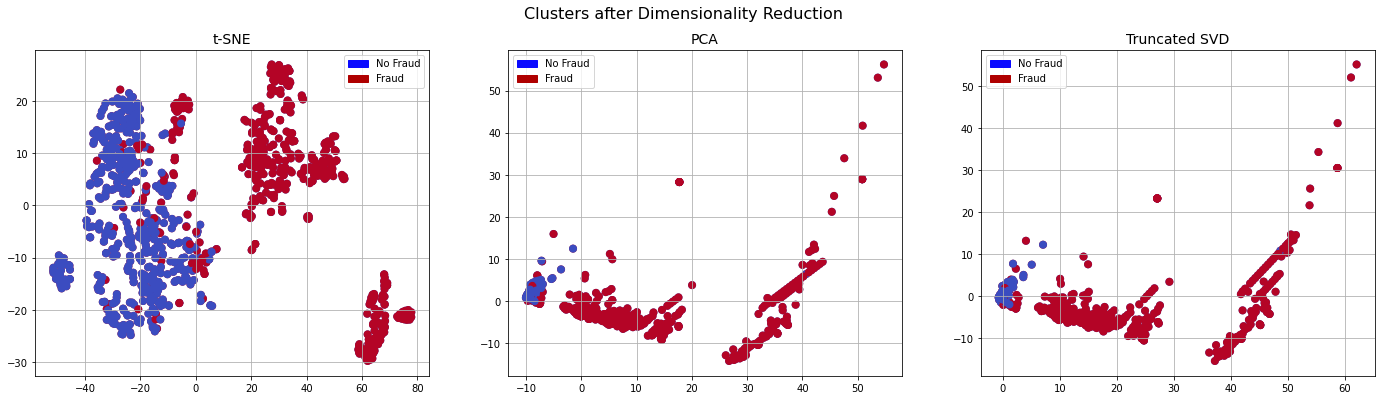

In [113]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
f.suptitle('Clusters after Dimensionality Reduction', fontsize=16)

# Label 범례 설정
labels = ['No Fraud', 'Fraud']
blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')
# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])
# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])
# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch]) ###

plt.show()

## Step 3. Random Undersampling 으로 샘플 재구축하기

### 문제 06. 재구축 샘플로 분류모델 구현하기

In [114]:
# 재구축한 데이터의 클래스 분포 확인하기

new_df.groupby(by=['Class']).count()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
Class,,,,,,,,,,,,,,,,,,,,,
0,492,492,492,492,492,492,492,492,492,492,...,492,492,492,492,492,492,492,492,492,492
1,492,492,492,492,492,492,492,492,492,492,...,492,492,492,492,492,492,492,492,492,492


In [115]:
# X와 y 데이터 셋 만들기
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [116]:
# 언더샘플링을 위한 샘플 데이터 구축
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [117]:
# 모델 인풋에 들어가기 위한 데이터의 형태 바꾸기
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [85]:
pip install lightgbm

     ---------------------------------------- 1.0/1.0 MB 2.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [118]:
# 학습시킬 모델 로드하기
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

classifiers = {
    "Logisitic Regression": LogisticRegression(),
    "K Nearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "LightGBM Classifier": LGBMClassifier()
}

In [119]:
# 모델별 cross validation 한 결과의 평균 정확도 점수 출력하기
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(classifier.__class__.__name__, ':', round(training_score.mean(), 2) * 100, '% accuracy')

LogisticRegression : 94.0 % accuracy
KNeighborsClassifier : 95.0 % accuracy
SVC : 94.0 % accuracy
DecisionTreeClassifier : 89.0 % accuracy
RandomForestClassifier : 94.0 % accuracy
GradientBoostingClassifier : 94.0 % accuracy
LGBMClassifier : 95.0 % accuracy


### 문제 07. 분류 결과 확인하기

In [ ]:
### 올바른 예

In [120]:
# 모델별 분류결과 확인하기 (올바른 예)
from sklearn.metrics import classification_report

for key, classifier in classifiers.items():
    y_pred = classifier.predict(X_test)  ####
    results = classification_report(y_test, y_pred)  ####
    print(classifier.__class__.__name__, '-------','\n', results)

LogisticRegression ------- 
               precision    recall  f1-score   support

           0       0.91      0.96      0.93       101
           1       0.96      0.90      0.92        96

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197

KNeighborsClassifier ------- 
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       101
           1       0.98      0.89      0.93        96

    accuracy                           0.93       197
   macro avg       0.94      0.93      0.93       197
weighted avg       0.94      0.93      0.93       197

SVC ------- 
               precision    recall  f1-score   support

           0       0.87      1.00      0.93       101
           1       1.00      0.84      0.92        96

    accuracy                           0.92       197
   macro avg       0.94      0.92      0.92       197


In [122]:
# 모델별 Confusion Matrix 확인하기 (올바른 예)
from sklearn.metrics import confusion_matrix

for key, classifier in classifiers.items():
    y_pred =classifier.predict(X_test) ####
    cm = confusion_matrix(y_test,y_pred) ####
    print(classifier.__class__.__name__, '\n', cm, '\n')

LogisticRegression 
 [[97  4]
 [10 86]] 

KNeighborsClassifier 
 [[99  2]
 [11 85]] 

SVC 
 [[101   0]
 [ 15  81]] 

DecisionTreeClassifier 
 [[89 12]
 [ 9 87]] 

RandomForestClassifier 
 [[99  2]
 [11 85]] 

GradientBoostingClassifier 
 [[98  3]
 [10 86]] 

LGBMClassifier 
 [[99  2]
 [ 8 88]] 



In [ ]:
### 잘못된 예

In [123]:
# 모델별 분류결과 확인하기
from sklearn.metrics import classification_report

for key, classifier in classifiers.items():
    y_pred = classifier.predict(X_test) ####
    results_wrong = classification_report(y_test, y_pred) ####
    print(classifier.__class__.__name__, '-------','\n', results_wrong)


LogisticRegression ------- 
               precision    recall  f1-score   support

           0       0.91      0.96      0.93       101
           1       0.96      0.90      0.92        96

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197

KNeighborsClassifier ------- 
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       101
           1       0.98      0.89      0.93        96

    accuracy                           0.93       197
   macro avg       0.94      0.93      0.93       197
weighted avg       0.94      0.93      0.93       197

SVC ------- 
               precision    recall  f1-score   support

           0       0.87      1.00      0.93       101
           1       1.00      0.84      0.92        96

    accuracy                           0.92       197
   macro avg       0.94      0.92      0.92       197


In [124]:
# 모델별 Confusion Matrix 확인하기 (잘못된 예)
from sklearn.metrics import confusion_matrix

for key, classifier in classifiers.items():
    y_pred = classifier.predict(X_test) ####
    results = classification_report(y_test, y_pred) ####
    print(classifier.__class__.__name__, '-------','\n', results)

LogisticRegression ------- 
               precision    recall  f1-score   support

           0       0.91      0.96      0.93       101
           1       0.96      0.90      0.92        96

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197

KNeighborsClassifier ------- 
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       101
           1       0.98      0.89      0.93        96

    accuracy                           0.93       197
   macro avg       0.94      0.93      0.93       197
weighted avg       0.94      0.93      0.93       197

SVC ------- 
               precision    recall  f1-score   support

           0       0.87      1.00      0.93       101
           1       1.00      0.84      0.92        96

    accuracy                           0.92       197
   macro avg       0.94      0.92      0.92       197


## Step 4. SMOTE 로 Oversampling 하기 

### 참고:

- 리샘플링(Synthetic Minority Oversampling Technique)

- 모델 파라미터 조정
    - `scale_pos_weight`
    - `is_unbalance`
    - `{class_label: weight}`

In [95]:
pip install imblearn

     -------------------------------------- 199.3/199.3 kB 2.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### 문제 08. SMOTE로 Oversampling하기

In [131]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X_train, list(y_train))  ####


print('Before SMOTE, original X_train: {}'.format(X_train.shape)) 
print('Before SMOTE, original y_train: {}'.format(np.array(y_train).shape))
print('After  SMOTE, resampled original X_train: {}'.format(X_resampled.shape)) 
print('After  SMOTE, resampled original y_train: {} \n'.format(np.array(y_resampled).shape))

print("Before SMOTE,     fraud counts: {}".format(sum(np.array(y_train)==1)))
print("Before SMOTE, non-fraud counts: {}".format(sum(np.array(y_train)==0)))
print("After  SMOTE,     fraud counts: {}".format(sum(np.array(y_resampled)==1)))
print("After  SMOTE, non-fraud counts: {}".format(sum(np.array(y_resampled)==0)))

Before SMOTE, original X_train: (787, 30)
Before SMOTE, original y_train: (787,)
After  SMOTE, resampled original X_train: (792, 30)
After  SMOTE, resampled original y_train: (792,) 

Before SMOTE,     fraud counts: 396
Before SMOTE, non-fraud counts: 391
After  SMOTE,     fraud counts: 396
After  SMOTE, non-fraud counts: 396


### 문제 09. 재구축한 샘플로 분류 모형 구현하기(2가지 방법)

In [ ]:
# 방법 1: 모델의 파라미터를 조정하는 방법 

In [132]:
from sklearn.metrics import accuracy_score, recall_score
# f1_score, roc_auc_score, precision_score

In [134]:
# Logistic Regression 모델의 weight 파라미터 지정하기

w = {1:0,1:99} ## 불균형 클래스 weight 파라미터 지정

# 모델 피팅
logreg_weighted = LogisticRegression(random_state=0, class_weight=w)  ###
logreg_weighted.fit(X_train,y_train ) ###

# 예측값 구하기
y_pred = logreg_weighted.predict(X_test) ###

# 예측 결과값 확인하기
print('Logistic Regression ------ Weighted')
print(f'Accuracy: {accuracy_score(y_test,y_pred) }')###

print('\n')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred) }')###

print('\n')
print(f'Recall: {recall_score(y_test,y_pred) }')###


Logistic Regression ------ Weighted
Accuracy: 0.7817258883248731


Confusion Matrix: 
[[60 41]
 [ 2 94]]


Recall: 0.9791666666666666


In [137]:
# imblearn 패키지를 이용하여 예측 결과 확인하기
from imblearn.metrics import classification_report_imbalanced

label = ['non-fraud', 'fraud'] 
print(classification_report_imbalanced(y_test, y_pred,target_names=label))

                   pre       rec       spe        f1       geo       iba       sup

  non-fraud       0.97      0.59      0.98      0.74      0.76      0.56       101
      fraud       0.70      0.98      0.59      0.81      0.76      0.60        96

avg / total       0.84      0.78      0.79      0.77      0.76      0.58       197



In [ ]:
# 방법 2: Resampling 으로 재구축한 샘플을 이용하는 방법

In [143]:
# 재구축한 샘플 데이터로 모델 피팅하기
logreg_resampled = LogisticRegression(random_state=0)  ###
logreg_resampled.fit(X_train, y_train  ) ###

# 예측값 구하기
y_pred = logreg_resampled.predict(X_test)

# 예측 결과값 확인하기
print('Logistic Regression ------ Resampled Data')
print(f'Accuracy: {accuracy_score(y_test,y_pred) }') ###

print('\n')
print(f'Confusion Matrix: \n{confusion_matrix(y_test,y_pred)}') ###

print('\n')
print(f'Recall: {recall_score(y_test,y_pred)}') ###

Logistic Regression ------ Resampled Data
Accuracy: 0.9289340101522843


Confusion Matrix: 
[[97  4]
 [10 86]]


Recall: 0.8958333333333334


In [145]:
# imblearn 패키지를 이용하여 예측 결과 확인하기
from imblearn.metrics import classification_report_imbalanced

label = ['non-Fraud','Fraud' ] 
print(classification_report_imbalanced(y_test,y_pred,target_names=label)) 

                   pre       rec       spe        f1       geo       iba       sup

  non-Fraud       0.91      0.96      0.90      0.93      0.93      0.87       101
      Fraud       0.96      0.90      0.96      0.92      0.93      0.85        96

avg / total       0.93      0.93      0.93      0.93      0.93      0.86       197



## Step 5. 요약

- 1) 불균형 분류 문제에 대한 이해: 사기탐지 데이터
- 2) 피처 변환 알고리즘의 이해: <b>PCA</b>, <b>t-SNE</b>, <b>SVD</b>
- 3) 과대적합 발생시 해결 방법 습득: 모델 파라미터 조정, 샘플 재구축
- 4) 리샘플링 알고리즘에 대한 이해: <b>Random Undersampling</b>, <b>Random Oversampling</b>, <b>SMOTE Oversampling</b> 등
- 5) 불균형 데이터를 이용한 분류 결과의 올바른 해석 방법 습득: `classification_report_imbalanced` 이용하기